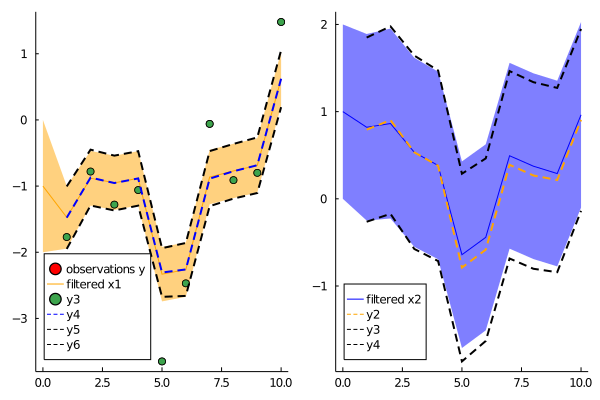

In [2]:
##################################
####  test of particle filter  ###
##################################

## run kalman filter example and copy with particle filter - save resutls 
using Kalman, GaussianDistributions, LinearAlgebra
using GaussianDistributions: ⊕ # independent sum of Gaussian r.v.
using Statistics, Distributions
include("../examples/linear_quadratic.jl")
include("particle_filter.jl")


# prior for time 0
x0 = [-1., 1.]

P0 = [1.0 0; 0 1.0]

# dynamics
phi = [0.8 0.2; -0.1 0.8]
b = zeros(2)
Q = [0.2 0.0; 0.0 0.5]

# observation
H = [1.0 0.0]
R = [0.3]

# (mock) data
ys = [[-1.77], [-0.78], [-1.28], [-1.06], [-3.65], [-2.47], [-0.06], [-0.91], [-0.80], [1.48]]


# filter (assuming first observation at time 1)
N = length(ys)

p = Gaussian(x0, P0)
ps = [p] # vector of filtered Gaussians
for i in 1:N
    global p
    # predict
    p = phi*p ⊕ Gaussian(zero(x0), Q) #same as Gaussian(Φ*p.μ, Φ*p.Σ*Φ' + Q)
    # correct
    p, yres, _ = Kalman.correct(Kalman.JosephForm(), p, (Gaussian(ys[i], R), H))
    push!(ps, p) # save filtered density
end

using Plots

p1 = scatter(1:N, first.(ys), color="red", label="observations y")
plot!(p1, 0:N, [mean(p)[1] for p in ps], color="orange", 
        label="filtered x1", grid=false, ribbon=[sqrt(cov(p)[1,1]) for p in ps], fillalpha=.5)
p2 = plot(0:N, [mean(p)[2] for p in ps], color="blue", 
        label="filtered x2", grid=false, ribbon=[sqrt(cov(p)[2,2]) for p in ps], fillalpha=.5)




## run particle filter 

pars = (phi, H, Distributions.MvNormal(b, Q), Distributions.MvNormal([0], sqrt.(R)))

function T!(x,c)
    return linear_quadratic.T!(x,c,pars)
end
function G(x,y,c)
    return linear_quadratic.G(x,y,c,pars)
end
function simulate_y(x)
    return linear_quadratic.simulate_y(x,pars)
end

# togle N to see resutls for differnt levels of precision 
N = 5000
prior = Distributions.MvNormal(x0, P0)
samples = rand(prior,N)

samples_ = [samples[:,1]]
for i in 2:N 
    push!(samples_, samples[:,i])
    #samples_ = vcat(samples_, [samples[:,i]]) 
end 
samples = samples_

weights = repeat([1.0/N],N)
POMP_ = particle_filter.POMP(samples,weights,N,G,T!)


ys = [[-1.77], [-0.78], [-1.28], [-1.06], [-3.65], [-2.47], [-0.06], [-0.91], [-0.80], [1.48]]


T_ = length(ys)
y_ = zeros(T_)
x_ = zeros(T_)
mean_ = zeros(T_)
upper = zeros(T_)
lower = zeros(T_)
mean_2 = zeros(T_)
upper_2 = zeros(T_)
lower_2 = zeros(T_)
for i in 1:T_
    y = ys[i]
    particle_filter.filter!(POMP_,y, 0.0)
    particle_filter.reweight_samples!(POMP_)
    y_[i] = y[1]
    mean_[i] = sum(broadcast(x -> x[1]/POMP_.N, POMP_.samples))
    sd_ = sqrt(sum(broadcast(x -> (x[1] -mean_[i])^2/POMP_.N, POMP_.samples)))
    upper[i] = mean_[i] + sd_
    lower[i] = mean_[i] - sd_
    
    mean_2[i] = sum(broadcast(x -> x[2]/POMP_.N, POMP_.samples))
    sd_ = sqrt(sum(broadcast(x -> (x[2] -mean_2[i])^2/POMP_.N, POMP_.samples)))
    upper_2[i] = mean_2[i] + sd_
    lower_2[i] = mean_2[i] - sd_
end 
p1_ = p1
Plots.scatter!(p1_,y_)
Plots.plot!(p1_,mean_, color = color = "blue", linestyle =:dash, linewidth = 2)
Plots.plot!(p1_,upper, color = color = "black", linestyle =:dash, linewidth = 2)
Plots.plot!(p1_,lower, color = color = "black", linestyle =:dash, 
            legend = :bottomleft, linewidth = 2)

p2_ = p2
Plots.plot!(p2_,mean_2, color = color = "orange", linestyle =:dash, linewidth = 2)
Plots.plot!(p2_,upper_2, color = color = "black", linestyle =:dash, linewidth = 2)
Plots.plot!(p2_,lower_2, color = color = "black", 
            linestyle =:dash, legend = :bottomleft,
            linewidth = 2)

plot(p1_,p2_)

In [108]:
include("../utils.jl")
include("particle_filter.jl")
samples,weights = particle_filter.GC_samples(50000,[0,1.0,-0.5])
utils.cumulant(samples, exp.(weights), 3)

-0.44018631197034697

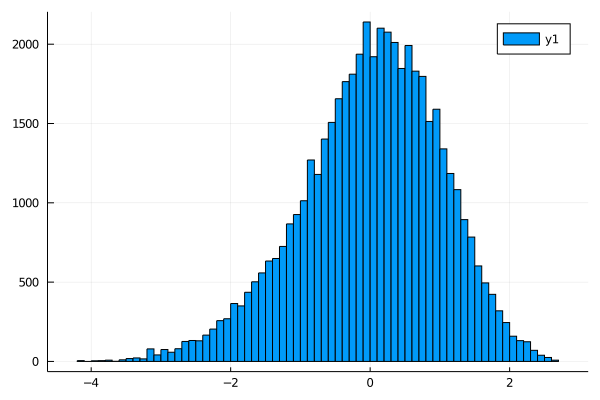

In [110]:
using StatsBase
N = length(samples)
inds = sample(collect(1:N),StatsBase.pweights(exp.(weights)),N)
samples = samples[inds]
Plots.histogram(samples)

In [27]:
sum(weights)

-1.553890022270025